<a href="https://colab.research.google.com/github/pingwx/ya.prac/blob/main/12_Time_series/12_EN_Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting taxi orders

The "Chetenkoe Taxi" company has collected historical data on taxi orders at airports. To attract more drivers during the peak period, we need to predict the number of taxi orders for the next hour. It is required to build a model for such a prediction.

The value of the *RMSE* metric on the test sample should not exceed 48.

The data is in the `taxi.csv` file. The number of orders is in the `num_orders` column.

## Preparation

In [ ]:
# !pip install catboost

In [2]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from matplotlib import pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
URL = # your dataset here

In [4]:
df = pd.read_csv(URL)

In [5]:
df.head(13)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


The data has been loaded. We see a dataset of two columns "datetime", "num_orders". There are no gaps. We will work with the dataset as with a time series. Let's convert the date column to the correct type.

In [7]:
try:
    df['datetime'] = pd.to_datetime(df['datetime'])
    print('success')
except:
    print('fail')

success


Let's convert the date column to index.

In [8]:
df = df.set_index('datetime')

We sort the dataset by index.

In [9]:
df = df.sort_index()

Let's resample the data to one hour time period.

In [10]:
df = df.resample('1H').sum()

In [11]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Since the data in the original dataset was sampled for 10 minutes, after resampling, the number of rows decreased by 6 times.

## Analysis

Let's analyze the data. First, let's resample the data for one day to look at it from a long-term point of view.

In [13]:
def decomposed_plots(decomposed):
    plt.figure(figsize=(16, 9))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    plt.tight_layout()

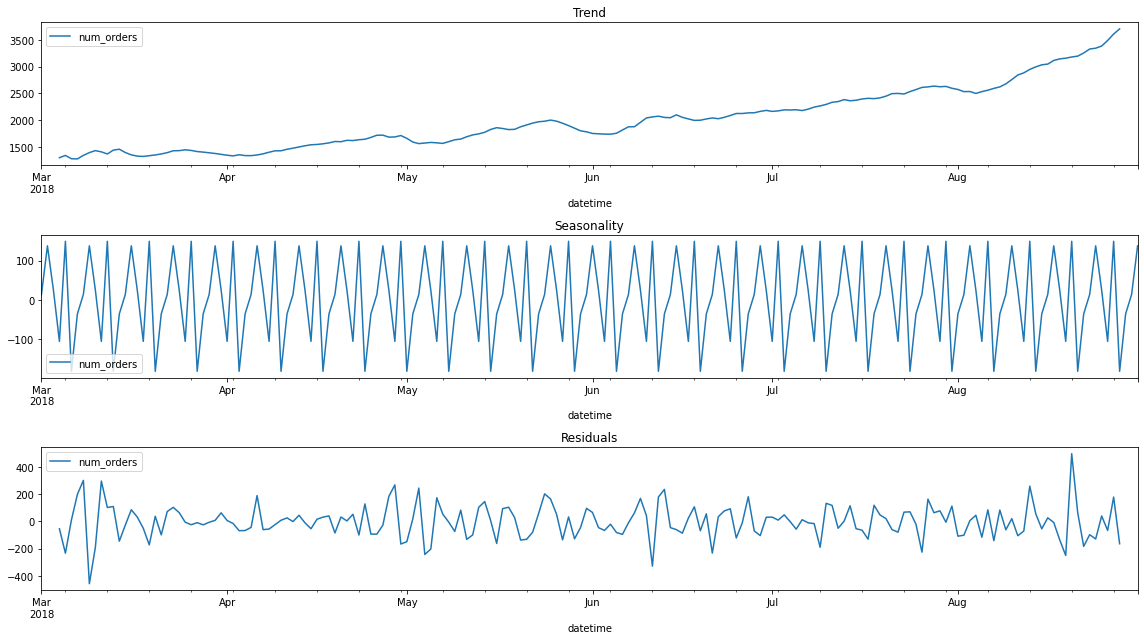

In [14]:
df_resampled_day = df.resample('1D').sum()
decomposed = seasonal_decompose(df_resampled_day)
decomposed_plots(decomposed)

We see that in the long term there is a trend towards an increase in the number of users. There is seasonality in the data, but it is not yet clear from this graph what caused it. There is also some noise in the data. Now let's look at the data in the context of one month.

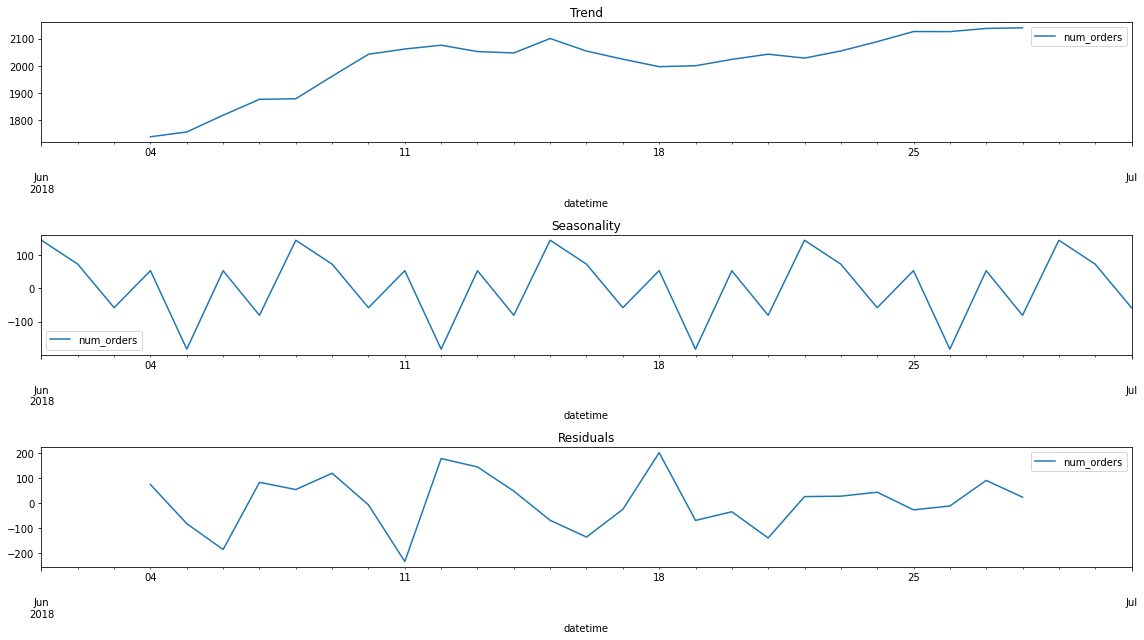

In [15]:
decomposed = seasonal_decompose(df_resampled_day['2018-06-1':'2018-07-1'])
decomposed_plots(decomposed)

In this approximation, the seasonal component is better understood. The number of orders depends on the day of the week (on the seasonality chart, repeating segments are 7 days long). Let's also look at the data on a two-day scale to understand what happens to orders within one day.

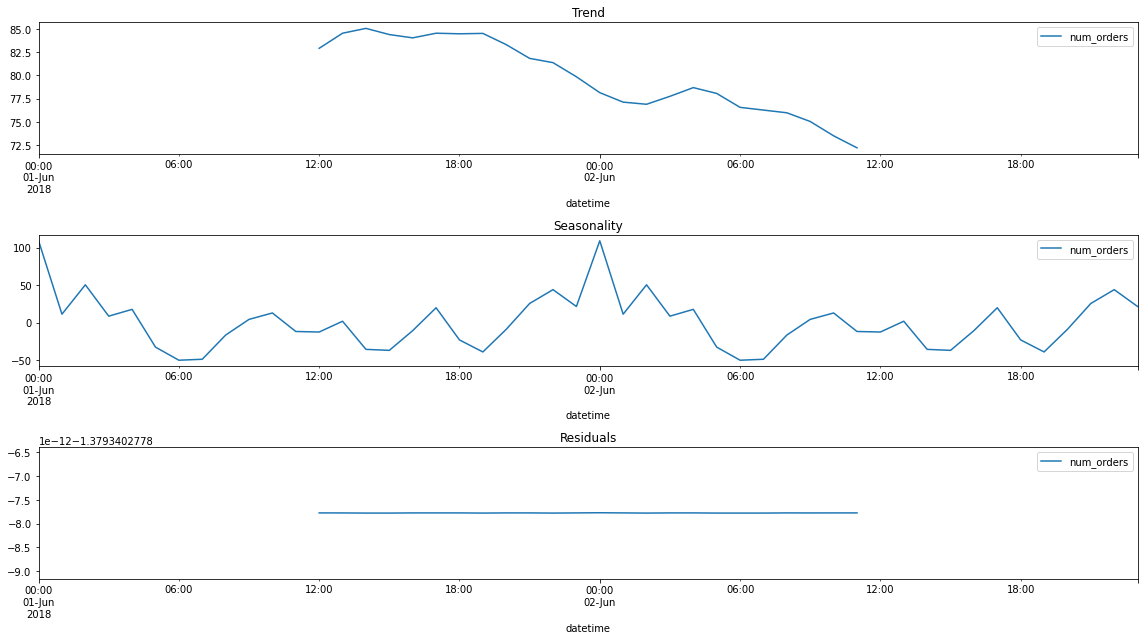

In [16]:
decomposed = seasonal_decompose(df['2018-06-1':'2018-06-2'])
decomposed_plots(decomposed)

Seasonality depending on the time of day is also observed. We see that the peak of orders falls at 00:00, then there is a sharp fall. In the morning there is a local maximum (people go to work), the second local maximum falls at 18:00 (people go from work).

## Fitting

Let us define a function that creates features. We will add calendar features that seems to be seasonal: month, day of the week, hour of the day. We will also add lagging values (lag features) and a moving average. The number of lag features and the value of the rolling interval are defined below in constants.

In [17]:
MAX_LAG = 256
ROLLING_SIZE = 24

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    data_featured = data.copy()
    data_featured['month'] = data_featured.index.month
    data_featured['hour'] = data_featured.index.hour
    data_featured['dayofweek'] = data_featured.index.dayofweek   
    for lag in range(1, max_lag + 1):
        data_featured['lag_{}'.format(lag)] = data_featured['num_orders'].shift(lag)
    data_featured['rolling_mean'] = data_featured['num_orders'].rolling(rolling_mean_size,
                                                 closed = 'left').mean()
    return data_featured

Let's add features to the dataset.

In [19]:
df_featured = make_features(df, MAX_LAG, ROLLING_SIZE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if __name__ == '__main__':


In [20]:
df_featured.head()

,num_orders,month,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_248,lag_249,lag_250,lag_251,lag_252,lag_253,lag_254,lag_255,lag_256,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Since there will be gaps in the first lines of the dataset in the columns of the lag, we will remove them.

In [21]:
df_featured = df_featured.dropna()

Let's split the dataset into training, validation and test sets

In [22]:
train, test = train_test_split(df_featured, shuffle=False, test_size=0.1)
train, val = train_test_split(train , shuffle=False, test_size=0.1)
train.shape, val.shape, test.shape

((3369, 261), (375, 261), (416, 261))

Make sure the dates in the selections are in the correct order.

In [23]:
train.head(1).index

DatetimeIndex(['2018-03-11 16:00:00'], dtype='datetime64[ns]', name='datetime', freq='H')

In [24]:
train.tail(1).index

DatetimeIndex(['2018-07-30'], dtype='datetime64[ns]', name='datetime', freq='H')

In [25]:
val.head(1).index

DatetimeIndex(['2018-07-30 01:00:00'], dtype='datetime64[ns]', name='datetime', freq='H')

In [26]:
val.tail(1).index

DatetimeIndex(['2018-08-14 15:00:00'], dtype='datetime64[ns]', name='datetime', freq='H')

In [27]:
test.head(1).index

DatetimeIndex(['2018-08-14 16:00:00'], dtype='datetime64[ns]', name='datetime', freq='H')

In [28]:
test.tail(1).index

DatetimeIndex(['2018-08-31 23:00:00'], dtype='datetime64[ns]', name='datetime', freq='H')

The order is correct. Let's train the models.

### Baseline

Let's see what value of RMSE we get if we always predict the previous value of the series.

In [29]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_val = val.drop('num_orders', axis=1)
y_val = val['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [30]:
pred = np.ones(val.shape[0])
pred[0] = y_train.iloc[len(y_train)-1]
pred[1:] = y_val.shift()[1:]
rmse = mean_squared_error(pred, y_val) ** 0.5
rmse

47.86765087196154

### LinearRegression

In [31]:
lr_model = make_pipeline(StandardScaler(), LinearRegression())
lr_model.fit(X_train, y_train)
pred = lr_model.predict(X_val)
rmse = mean_squared_error(y_val, pred) ** 0.5
rmse

29.169968004447526

### Catboost

In [32]:
cb_model = CatBoostRegressor()
cb_model.fit(X_train, y_train, verbose=200)
pred = cb_model.predict(X_val)
rmse = mean_squared_error(y_val, pred) ** 0.5
rmse

Learning rate set to 0.049605
0:	learn: 35.5076856	total: 241ms	remaining: 4m 1s
200:	learn: 16.6533899	total: 24.2s	remaining: 1m 36s
400:	learn: 13.4260683	total: 49s	remaining: 1m 13s
600:	learn: 11.0997398	total: 1m 9s	remaining: 45.9s
800:	learn: 9.1835610	total: 1m 19s	remaining: 19.8s
999:	learn: 7.6947087	total: 1m 30s	remaining: 0us


29.20016906281623

### Torch NN model

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Transform values to torch.Tensor

X_train_tensor = torch.from_numpy(X_train.values.astype(np.float32))
X_val_tensor = torch.from_numpy(X_val.values.astype(np.float32))
y_train_tensor = torch.from_numpy(y_train.values.astype(np.float32))
y_val_tensor = torch.from_numpy(y_val.values.astype(np.float32))
X_test_tensor = torch.from_numpy(X_test.values.astype(np.float32))
y_test_tensor = torch.from_numpy(y_test.values.astype(np.float32))
y_train_tensor = y_train_tensor.unsqueeze(1)
y_val_tensor = y_val_tensor.unsqueeze(1)

Using cpu device


In [34]:
# Create data loaders
BATCH_SIZE = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [35]:
# The architecture of the model
nn_model = nn.Sequential(
    nn.Linear(X_train.shape[1], 128),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(128,1)
)

In [36]:
# Loss function and optimizer
nn_model.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=3e-4)

In [37]:
def train_model(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader)
    model.train() # model in train mode
    for batch, (X, y) in enumerate(dataloader): # iterate over batches
        X, y = X.to(device), y.to(device)
        train_loss = 0
        pred = model(X) # make a prediction
        loss = loss_fn(pred, y) # calculate the loss on the batch
        train_loss += loss.item() # total loss per epoch
        optimizer.zero_grad() # reset the gradients
        loss.backward() # calculated the gradients
        optimizer.step() # made a step on the anti-gradient
    train_loss /= num_batches
    print(f"Train avg loss: {train_loss:>8f}")
    
def valid_model(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval() # model to eval mode
    test_loss = 0
    with torch.no_grad(): # no need for gradients here
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Val avg loss: {test_loss:>8f} \n")

In [38]:
epochs = 30
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_model(train_dataloader, nn_model, loss_fn, optimizer)
    valid_model(val_dataloader, nn_model, loss_fn)

Epoch 1
-------------------------------
Train avg loss: 41.743127
Val avg loss: 1307.320033 

Epoch 2
-------------------------------
Train avg loss: 9.308891
Val avg loss: 1042.333700 

Epoch 3
-------------------------------
Train avg loss: 16.258103
Val avg loss: 995.086736 

Epoch 4
-------------------------------
Train avg loss: 11.872373
Val avg loss: 958.052699 

Epoch 5
-------------------------------
Train avg loss: 8.212314
Val avg loss: 919.968857 

Epoch 6
-------------------------------
Train avg loss: 10.785521
Val avg loss: 916.988309 

Epoch 7
-------------------------------
Train avg loss: 12.477610
Val avg loss: 906.009911 

Epoch 8
-------------------------------
Train avg loss: 10.263976
Val avg loss: 946.333974 

Epoch 9
-------------------------------
Train avg loss: 17.389802
Val avg loss: 893.230225 

Epoch 10
-------------------------------
Train avg loss: 15.759895
Val avg loss: 883.665047 

Epoch 11
-------------------------------
Train avg loss: 18.037936
Va

In [39]:
pred = nn_model(X_val_tensor).cpu().detach().numpy()
rmse = mean_squared_error(y_val, pred) ** 0.5
rmse

29.125812055240193

### Results

The results of the models depending on the values of MAX_LAG and ROLLING_SIZE

**MAX_LAG = 5, ROLLING_SIZE = 5**

In [40]:
pd.DataFrame([['LR', 40.6645], ['CatBoost', 32.9562], ['NN', 42.2728]], columns=['model', 'RMSE'])

,model,RMSE
0,LR,40.6645
1,CatBoost,32.9562
2,NN,42.2728


**MAX_LAG = 10, ROLLING_SIZE = 10**

In [41]:
pd.DataFrame([['LR', 40.3110], ['CatBoost', 31.9200], ['NN', 40.6148]], columns=['model', 'RMSE'])

,model,RMSE
0,LR,40.3110
1,CatBoost,31.9200
2,NN,40.6148


**MAX_LAG = 50, ROLLING_SIZE = 10**

In [42]:
pd.DataFrame([['LR', 31.3829], ['CatBoost', 29.8182], ['NN', 31.0938]], columns=['model', 'RMSE'])

,model,RMSE
0,LR,31.3829
1,CatBoost,29.8182
2,NN,31.0938


**MAX_LAG = 50, ROLLING_SIZE = 50**

In [43]:
pd.DataFrame([['LR', 31.3855], ['CatBoost', 29.8337], ['NN', 31.1579]], columns=['model', 'RMSE'])

,model,RMSE
0,LR,31.3855
1,CatBoost,29.8337
2,NN,31.1579


**MAX_LAG = 100, ROLLING_SIZE = 24**

In [44]:
pd.DataFrame([['LR', 29.5466], ['CatBoost', 29.2311], ['NN', 29.3392]], columns=['model', 'RMSE'])

,model,RMSE
0,LR,29.5466
1,CatBoost,29.2311
2,NN,29.3392


**MAX_LAG = 256, ROLLING_SIZE = 24**

In [45]:
pd.DataFrame([['LR', 29.3012], ['CatBoost', 29.4277], ['NN', 29.2203]], columns=['model', 'RMSE'])

,model,RMSE
0,LR,29.3012
1,CatBoost,29.4277
2,NN,29.2203


### Conclusion:

Adding lag features obviously affects how the model works. However, after the value MAX_LAG = 100, there is practically no increase in the quality of the models. With large MAX_LAG values, the models have approximately the same quality. ROLLING_SIZE has little effect on how models work. Catboost shows close to the maximum possible RMSE even with small MAX_LAG and ROLLING_SIZE.

## Testing

Let's run the models on a test set.

**LR:**

In [46]:
pred_lr = lr_model.predict(X_test)
rmse_lr = mean_squared_error(y_test, pred_lr) ** 0.5
rmse_lr

34.910333739339414

**CatBoost:**

In [47]:
pred_cb = cb_model.predict(X_test)
rmse_cb = mean_squared_error(y_test, pred_cb) ** 0.5
rmse_cb

41.5337795686949

**NN:**

In [48]:
pred_nn = nn_model(X_test_tensor).cpu().detach().numpy()
rmse_nn = mean_squared_error(y_test, pred_nn) ** 0.5
rmse_nn

37.28965691930036

### Graphs

In [49]:
pred_cb = pd.DataFrame(data=pred_cb, index=y_test.index, columns=['catboost'])
pred_nn = pd.DataFrame(data=pred_nn, index=y_test.index, columns=['NN'])
pred_lr = pd.DataFrame(data=pred_lr, index=y_test.index, columns=['LR'])

**LR:**

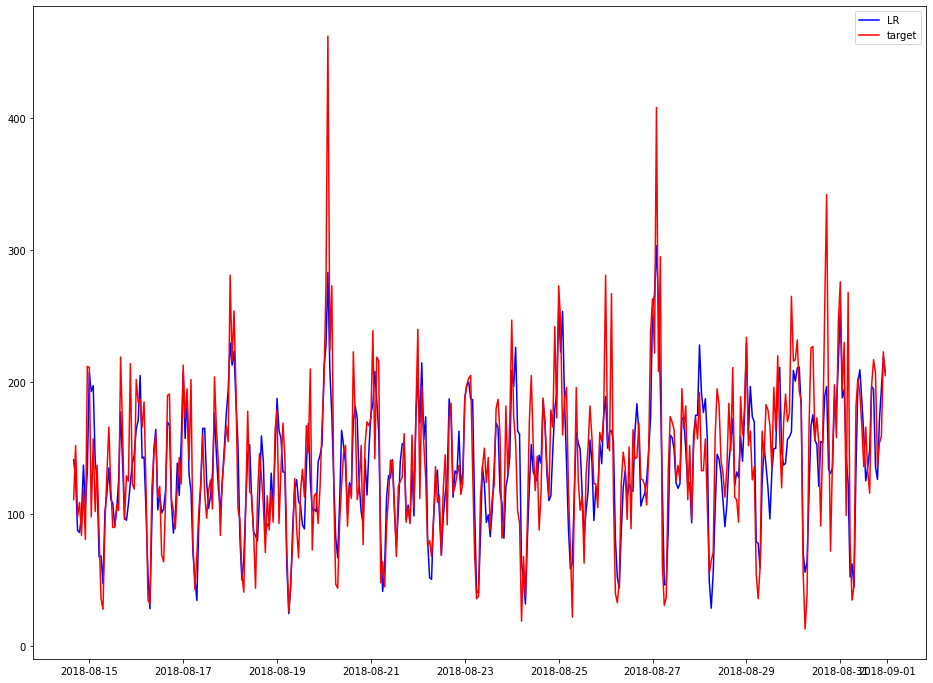

In [50]:
plt.figure(figsize=(16,12))
plt.plot(pred_lr, color='b', label='LR')
plt.plot(y_test, color='r', label='target')
plt.legend()
plt.show()

**CatBoost:**

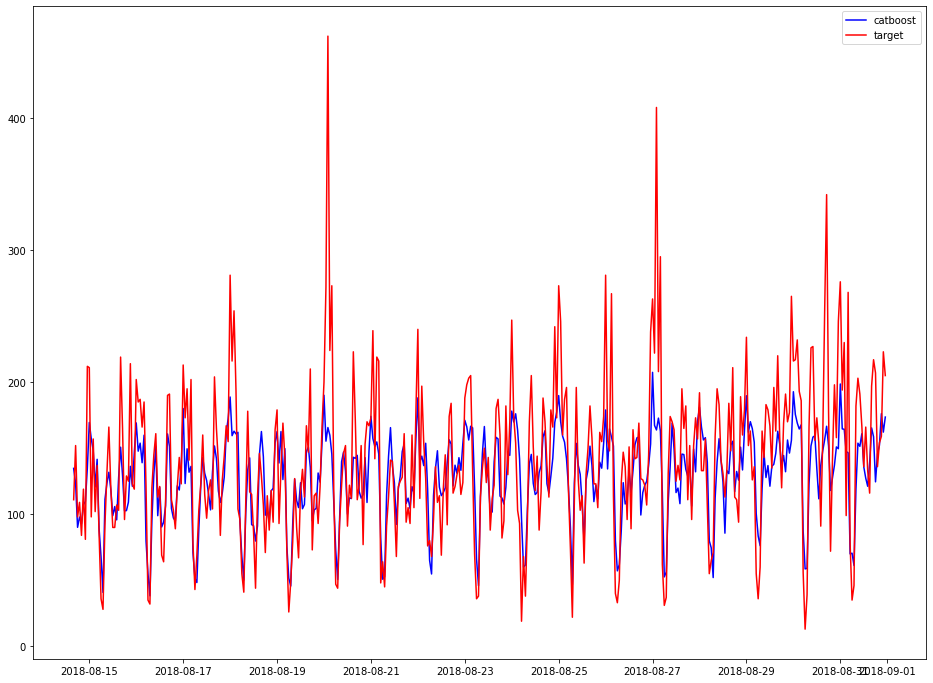

In [51]:
plt.figure(figsize=(16,12))
plt.plot(pred_cb, color='b', label='catboost')
plt.plot(y_test, color='r', label='target')
plt.legend()
plt.show()

**NN:**

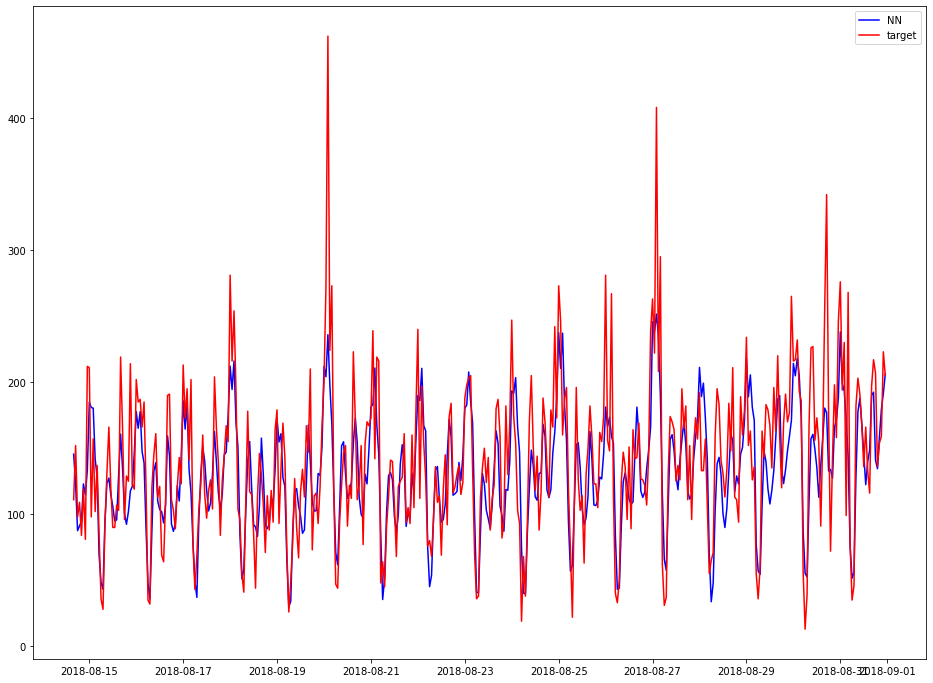

In [52]:
plt.figure(figsize=(16,12))
plt.plot(pred_nn, color='b', label='NN')
plt.plot(y_test, color='r', label='target')
plt.legend()
plt.show()

### Conclusions:

As already noted, after a certain value of MAX_LAG, the quality of the models becomes approximately the same. However, we note the following: if many lag columns are fed into linear regression, then its error becomes comparable to more complex models, but it gives more "stable" predictions for forecasts. In this case, we see that the result of Catboost on the test is even worse than the LR. The neural network is somewhere in the middle between LR and Catboost. Note that all the constructed models surpassed the baseline. Note that the values ​​of errors in validation and test differ significantly. This is explained by the fact that the validation data is closer to the training data than the test data (the test data is the most recent). Thus, we see that the quality of the model may deteriorate over time. And from here, in turn, it follows that time series prediction models require regular support (additional training on fresh data, revision of the model itself).